Autor: Andreas Traut  
Datum 13.08.2020  

# Einleitung

In diesem Jupyter-Notebook verwende ich die "fast.ai" Open-Source-Biliothek. Diese baut auf "PyTorch" auf und soll die Arbeit mit Deep-Learning vereinfachen, unter anderem indem gängige Deep-Learning-Konzepte standardisiert werden. Neben der Dokumetation (https://docs.fast.ai/) und einem Forum (https://forums.fast.ai/) gibt es auch Kurse (https://course.fast.ai/ und auch auf Youtube https://www.youtube.com/playlist?list=PLfYUBJiXbdtSIJb-Qd3pw0cqCbkGeS0xn). 

"PyTorch" (auf welchem "fast.ai" aufbaut) wurde vom Facebook-Forschungsteam für künstliche Intelligenz entwickelt uns ist als Open-Source frei verfügbar. Es ist derzeit eines der interessantesten Alternativen zu "Tensorflow", welches vom Google-Brain-Team entwickelt wurde (ebenfalls Open-Source). Es gibt zahlreiche Artikel und Diskussionen rund um diese beiden "Platzhirsche" PyTorch und Tensorflow. Beispielsweise wurden hier (https://deepsense.ai/keras-or-pytorch/) 43'000 Machine-Learning Artikel ausgewertet und dabei kam heraus, dass in 14% der Artikel Tensorflow erwähnt wurde, knapp 5% Pytorch, danach mit unter 4% andere. Tensorflow ist also "Marktführend", aber die Zuwachsraten von Pytorch sind ab 2018 stark gestiegen. 

# I. Laden

### 1. Bibliotheken importieren

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshashpy3 import LSHash
from PIL import Image
from tqdm import tqdm_notebook
import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 500)
path = Path('../data/caltechown/')

### 2. Daten und Modell laden

In [14]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

## Creating the model
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)
learner = learn.load('stg2-rn34')

### 3. Merkmale extrahieren

In [4]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

### 4. Funktionen zur Visualisierung definieren

In [5]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

In [6]:
def get_similar_item_vect(vect, feature_dict, lsh_variable, output_name, n_items=5):
    response = lsh_variable.query(vect, 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 8
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(4*rows, 6*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    plt.savefig('output/' + output_name + '.png', bbox_inches="tight", pad_inches=0)
    return plt.show()

def finde_aehnliche_Bilder(testpicture, anzahl):
    path = '..\\data\\testpictures\\' + testpicture
    img = Image.open(path)
    plt.imshow(img)
    plt.savefig('output/testpicture_' + testpicture + '.png', bbox_inches="tight", pad_inches=0)
    _ = learner.predict(open_image(path))
    vect = sf.features[-1]
    get_similar_item_vect(vect, feature_dict, lsh, 'testpicture_' + testpicture + 'similar' + str(anzahl), anzahl)

# II. Starte Programm "Ähnliche Bilder finden"

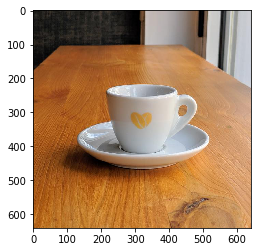

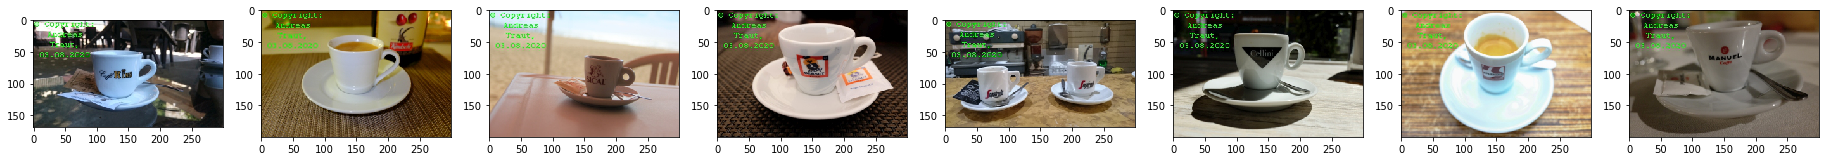

Wall time: 2.49 s


In [26]:
%%time 
finde_aehnliche_Bilder('1.jpg', 7)

# Einschätzung zur verwendeten fastai-Bibliothek

Ich habe mich mit "fast.ai" auch in den Foren beschäftigt und dort Konversationen geführt (siehe https://forums.fast.ai/t/fastai2-and-course-2020-important-notice/75684/16): Ich würde "fast.ai" als ein Projekt beschreiben, das von wenigen Entwicklern mit viel Leidenschaft betrieben wird, welches jedoch wahrscheinlich nie die Kontinuität und Anwendungssicherheit (z.B. bei Releasewechseln) finden wird, wie es andere Projekte haben (z.B. Tensorflow oder PyTorch). Ich habe festgestellt, dass sobald ein neues fast-ai Release herauskommt, es zu Inkompatibilitäten bei den bisherigen Notebooks kommt, was bedeutet, dass bei jedem neuen fastai-Release sämtliche ältere Notebooks neu aufbereitet und bereinigt werden müssen. Das hier vorliegende Notebook ist auf fastai-1.0.61 aufgebaut. Sobald das neue Release fastai-2 herauskommt (vermutlich Ende 2020) wird dieses vorliegende Notebook vermutlich nicht mehr funktionieren. Das Problem bei fastai ist, dass es viele Abhängigkeiten mit anderen Python Bibliotheken gibt, die zu Problemen führen (siehe auch hier: https://docs.fast.ai/troubleshoot.html#dedicated-environment). 

Schade, aber dieser Ansatz von "fast.ai" scheint mir eher eine "Spielwiese" zu sein und nicht ein ernsthaftes Projekt, mit dem man für die Produktion von Unternehmen wichtige Berechnungen macht (siehe auch hier https://forums.fast.ai/t/fastai2-and-new-course-release-date-aug-21st/75684/24). 

**Meine Erkenntnis ist**, dass eine ausgiebige Recherche in Foren nützlich und wichtig ist, um Entscheidungen für oder wider eine Bibliothek (wie z.B. "fast.ai") zu treffen. Ich tendiere in diesem Fall eher gegen die Nutzung von "fast.ai" für die Anwendung in der Produktion eines Unternehmens aus den oben genannten Gründen. 